In [223]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [224]:
df = pd.read_csv('data.csv')

In [225]:
df.shape

(9529, 19)

In [226]:
df.head(2)

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median
0,1,Manchester United,Jack Butland,Goalkeeper,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper,1304.0
1,2,Manchester United,Tom Heaton,Goalkeeper,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper,292.0


##  Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [227]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,Id,team,name,position,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped,minutes_played_median


In [228]:
df.drop(['Id','minutes_played_median','position','name'], axis=1, inplace=True)


In [229]:
# Completeness
df.isnull().sum()

team                0
age                 0
appearance          0
goals               0
assists             0
goals conceded      0
clean sheets        0
minutes played      0
days_injured        0
games_injured       0
award               0
current_value       0
highest_value       0
position_encoded    0
position_grouped    0
dtype: int64

In [230]:
# Accurecy types
df.dtypes

team                 object
age                 float64
appearance            int64
goals               float64
assists             float64
goals conceded      float64
clean sheets        float64
minutes played        int64
days_injured          int64
games_injured         int64
award                 int64
current_value         int64
highest_value         int64
position_encoded      int64
position_grouped     object
dtype: object

In [231]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = [ 'team']
numeric_features = [ 'position_grouped', 'position_encoded','highest_value','current_value','award','games_injured','days_injured','minutes played','clean sheets','goals conceded','assists','goals','appearance','age']

In [232]:
for i in categorical_features:
    print (df[i].value_counts())

team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swallows FC        39
                   ..
Gaziantep FK        5
Manchester City     5
Real Madrid         5
FC Barcelona        5
Bayern Munich       4
Name: count, Length: 374, dtype: int64


In [233]:
for i in categorical_features:
    print (df[i].value_counts())

team
FC Seoul           42
Daegu FC           41
Royal AM FC        40
Gangwon FC         40
Swallows FC        39
                   ..
Gaziantep FK        5
Manchester City     5
Real Madrid         5
FC Barcelona        5
Bayern Munich       4
Name: count, Length: 374, dtype: int64


In [234]:
for i in numeric_features:
    print (df[i].value_counts())

position_grouped
Defender Centre-Back          1683
Goalkeeper                    1172
midfield-CentralMidfield      1046
Attack Centre-Forward         1011
midfield-DefensiveMidfield     828
Defender Right-Back            808
Defender Left-Back             753
midfield-AttackingMidfield     645
Attack-RightWinger             613
Attack-LeftWinger              591
Other                          379
Name: count, dtype: int64
position_encoded
2    3277
3    2766
4    2314
1    1172
Name: count, dtype: int64
highest_value
1000000     440
1500000     393
2000000     380
50000       334
3000000     325
           ... 
3100000       1
90000000      1
80000000      1
37000000      1
625000        1
Name: count, Length: 141, dtype: int64
current_value
1000000     429
300000      425
500000      404
50000       391
1500000     383
           ... 
4400000       1
1750000       1
925000        1
21000000      1
3100000       1
Name: count, Length: 103, dtype: int64
award
0     4461
1     2049
2  

#### 2. Feature engineering

1. Feature scaling

2. Aggregation

3. One hot coding

In [235]:
df.head(2)

,team,age,appearance,goals,assists,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,position_grouped
0,Manchester United,30.0,15,0.0,0.0,1.242331,0.207055,1304,510,58,1,1500000,22000000,1,Goalkeeper
1,Manchester United,37.0,4,0.0,0.0,0.616438,0.924658,292,697,84,4,600000,6000000,1,Goalkeeper


In [236]:
categorical_features

['team']

In [237]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [238]:
df.shape

(9529, 388)

In [239]:
# Calculate the 35th and 75th percentiles of the price
p25 = df['current_value'].quantile(0.25)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(current_value):
    if current_value < p25:
        return 'Average Player'
    elif current_value < p75:
        return 'Good Player'
    else:
        return 'Professional Player'

# Apply the function to create a new column
df['player_leval_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_leval_category'].value_counts())

player_leval_category
Good Player            4710
Professional Player    2443
Average Player         2376
Name: count, dtype: int64


In [240]:
p25,p75

(np.float64(300000.0), np.float64(2500000.0))

In [241]:
encoder = LabelEncoder()
df['player_leval_category_encoded'] = encoder.fit_transform(df['player_leval_category']) 

#### 3. Feature selection

In [242]:
correlation = df.corr(numeric_only=True)
print(correlation['player_leval_category_encoded'].sort_values(ascending=False))

player_leval_category_encoded    1.000000
highest_value                    0.535701
appearance                       0.522449
minutes played                   0.492813
assists                          0.282450
                                   ...   
team_Al-Adalah FC               -0.069449
team_Al-Batin FC                -0.072292
team_Royal AM FC                -0.075967
team_Marumo Gallants FC         -0.076551
goals conceded                  -0.133234
Name: player_leval_category_encoded, Length: 387, dtype: float64


In [243]:
# Set the correlation threshold
threshold = 0.2  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_leval_category_encoded']) > \
threshold]['player_leval_category_encoded'].index
selected_features

Index(['appearance', 'goals', 'assists', 'minutes played', 'days_injured',
       'games_injured', 'award', 'highest_value',
       'player_leval_category_encoded'],
      dtype='object')

In [244]:
selected_features = ['appearance', 'minutes played', 'days_injured', 'games_injured',
       'award', 'highest_value', 'player_leval_category_encoded']

In [245]:
df = df[selected_features]
df.head()

,appearance,minutes played,days_injured,games_injured,award,highest_value,player_leval_category_encoded
0,15,1304,510,58,1,22000000,1
1,4,292,697,84,4,6000000,1
2,68,4762,148,27,1,70000000,2
3,70,5471,95,19,10,35000000,2
4,34,2758,47,13,0,2000000,1


### 4. Prepare train and test data

In [246]:
# Prepare data
X = df.drop(['player_leval_category_encoded'], axis=1)
y = df['player_leval_category_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [247]:
X.shape

(9529, 6)

## Buliding the Model


In [248]:
model = KNeighborsClassifier()

In [249]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           verbose=1)

### Train the Model

In [250]:
# Fit the model on the training data
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7]}, scoring='f1_macro',
             verbose=1)

In [251]:
grid_search.best_params_

{'n_neighbors': 5}

In [252]:
model = grid_search.best_estimator_

## Test the Model

In [253]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

### Evaluating the Model


In [254]:
# our benchmark model
base_model = round(df['player_leval_category_encoded'].value_counts()[1]/df.shape[0]*100, 2)
base_model

np.float64(49.43)

1. Accuracy

In [255]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7507869884575026

In [256]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8288075560802833

2. Confusion Matrix

In [257]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[287, 166,   9],
       [ 86, 760,  92],
       [  3, 119, 384]])

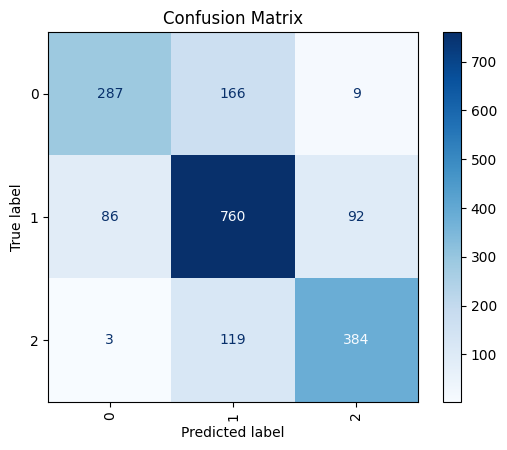

In [258]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

3. Precision

In [259]:
# Calculate Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.76


4. Recall

In [260]:
# Calculate Recall
recall = recall_score(y_test, y_pred, average='macro')

print(f"Recall: {recall:.2f}")

Recall: 0.73


5. F1 Score

In [261]:
# Calculate F1 Score
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.74
